In [1]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
from importlib import reload
import warnings
from pprint import pprint
import string
import pyLDAvis.gensim as gensimvis
import pickle 
import pyLDAvis
plt.style.use('bmh')
# mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [2]:
# !pip install pygsheets

In [3]:
STOPWORDS.update(["a","will","el","del","lo", "abord", "absolument", "afin", "ah", "ai", "aie", "aient", "aies", "ailleurs", "ainsi", "ait", "allaient", "allo",
 "allons", "allô", "alors", "anterieur", "anterieure", "anterieures", "apres", "après", "as", "assez", "attendu", "au",
 "aucun", "aucune", "aucuns", "aujourd", "aujourd'hui", "aupres", "auquel", "aura", "aurai", "auraient", "aurais",
 "aurait", "auras", "aurez", "auriez", "aurions", "aurons", "auront", "aussi", "autant", "autre", "autrefois",
 "autrement", "autres", "autrui", "aux", "auxquelles", "auxquels", "avaient", "avais", "avait", "avant", "avec", "avez",
 "aviez", "avions", "avoir", "avons", "ayant", "ayez", "ayons", "b", "bah", "bas", "basee", "bat", "beau", "beaucoup",
 "bien", "bigre", "bon", "boum", "bravo", "brrr", "c", "car", "ce", "ceci", "cela", "celle", "celle-ci", "celle-là",
 "celles", "celles-ci", "celles-là", "celui", "celui-ci", "celui-là", "celà", "cent", "cependant", "certain",
 "certaine", "certaines", "certains", "certes", "ces", "cet", "cette", "ceux", "ceux-ci", "ceux-là", "chacun",
 "chacune", "chaque", "cher", "chers", "chez", "chiche", "chut", "chère", "chères", "ci", "cinq", "cinquantaine",
 "cinquante", "cinquantième", "cinquième", "clac", "clic", "combien", "comme", "comment", "comparable", "comparables",
 "compris", "concernant", "contre", "couic", "crac", "d", "da", "dans", "de", "debout", "dedans", "dehors", "deja",
 "delà", "depuis", "dernier", "derniere", "derriere", "derrière", "des", "desormais", "desquelles", "desquels",
 "dessous", "dessus", "deux", "deuxième", "deuxièmement", "devant", "devers", "devra", "devrait", "different",
 "differentes", "differents", "différent", "différente", "différentes", "différents", "dire", "directe", "directement",
 "dit", "dite", "dits", "divers", "diverse", "diverses", "dix", "dix-huit", "dix-neuf", "dix-sept", "dixième", "doit",
 "doivent", "donc", "dont", "dos", "douze", "douzième", "dring", "droite", "du", "duquel", "durant", "dès", "début",
 "désormais", "e", "effet", "egale", "egalement", "egales", "eh", "elle", "elle-même", "elles", "elles-mêmes", "en",
 "encore", "enfin", "entre", "envers", "environ", "es", "essai", "est", "et", "etant", "etc", "etre", "eu", "eue",
 "eues", "euh", "eurent", "eus", "eusse", "eussent", "eusses", "eussiez", "eussions", "eut", "eux", "eux-mêmes",
 "exactement", "excepté", "extenso", "exterieur", "eûmes", "eût", "eûtes", "f", "fais", "faisaient", "faisant", "fait",
 "faites", "façon", "feront", "fi", "flac", "floc", "fois", "font", "force", "furent", "fus", "fusse", "fussent",
 "fusses", "fussiez", "fussions", "fut", "fûmes", "fût", "fûtes", "g", "gens", "h", "ha", "haut", "hein", "hem", "hep",
 "hi", "ho", "holà", "hop", "hormis", "hors", "hou", "houp", "hue", "hui", "huit", "huitième", "hum", "hurrah", "hé",
 "hélas", "i", "ici", "il", "ils", "importe", "j", "je", "jusqu", "jusque", "juste", "k", "l", "la", "laisser",
 "laquelle", "las", "le", "lequel", "les", "lesquelles", "lesquels", "leur", "leurs", "longtemps", "lors", "lorsque",
 "lui", "lui-meme", "lui-même", "là", "lès", "m", "ma", "maint", "maintenant", "mais", "malgre", "malgré", "maximale",
 "me", "meme", "memes", "merci", "mes", "mien", "mienne", "miennes", "miens", "mille", "mince", "mine", "minimale",
 "moi", "moi-meme", "moi-même", "moindres", "moins", "mon", "mot", "moyennant", "multiple", "multiples", "même",
 "mêmes", "n", "na", "naturel", "naturelle", "naturelles", "ne", "neanmoins", "necessaire", "necessairement", "neuf",
 "neuvième", "ni", "nombreuses", "nombreux", "nommés", "non", "nos", "notamment", "notre", "nous", "nous-mêmes",
 "nouveau", "nouveaux", "nul", "néanmoins", "nôtre", "nôtres", "o", "oh", "ohé", "ollé", "olé", "on", "ont", "onze",
 "onzième", "ore", "ou", "ouf", "ouias", "oust", "ouste", "outre", "ouvert", "ouverte", "ouverts", "o|", "où", "p",
 "paf", "pan", "par", "parce", "parfois", "parle", "parlent", "parler", "parmi", "parole", "parseme", "partant",
 "particulier", "particulière", "particulièrement", "pas", "passé", "pendant", "pense", "permet", "personne",
 "personnes", "peu", "peut", "peuvent", "peux", "pff", "pfft", "pfut", "pif", "pire", "pièce", "plein", "plouf",
 "plupart", "plus", "plusieurs", "plutôt", "possessif", "possessifs", "possible", "possibles", "pouah", "pour",
 "pourquoi", "pourrais", "pourrait", "pouvait", "prealable", "precisement", "premier", "première", "premièrement",
 "pres", "probable", "probante", "procedant", "proche", "près", "psitt", "pu", "puis", "puisque", "pur", "pure", "q",
 "qu", "quand", "quant", "quant-à-soi", "quanta", "quarante", "quatorze", "quatre", "quatre-vingt", "quatrième",
 "quatrièmement", "que", "quel", "quelconque", "quelle", "quelles", "quelqu'un", "quelque", "quelques", "quels", "qui",
 "quiconque", "quinze", "quoi", "quoique", "r", "rare", "rarement", "rares", "relative", "relativement", "remarquable",
 "rend", "rendre", "restant", "reste", "restent", "restrictif", "retour", "revoici", "revoilà", "rien", "s", "sa",
 "sacrebleu", "sait", "sans", "sapristi", "sauf", "se", "sein", "seize", "selon", "semblable", "semblaient", "semble",
 "semblent", "sent", "sept", "septième", "sera", "serai", "seraient", "serais", "serait", "seras", "serez", "seriez",
 "serions", "serons", "seront", "ses", "seul", "seule", "seulement", "si", "sien", "sienne", "siennes", "siens",
 "sinon", "six", "sixième", "soi", "soi-même", "soient", "sois", "soit", "soixante", "sommes", "son", "sont", "sous",
 "souvent", "soyez", "soyons", "specifique", "specifiques", "speculatif", "stop", "strictement", "subtiles",
 "suffisant", "suffisante", "suffit", "suis", "suit", "suivant", "suivante", "suivantes", "suivants", "suivre", "sujet",
 "superpose", "sur", "surtout", "t", "ta", "tac", "tandis", "tant", "tardive", "te", "tel", "telle", "tellement",
 "telles", "tels", "tenant", "tend", "tenir", "tente", "tes", "tic", "tien", "tienne", "tiennes", "tiens", "toc", "toi",
 "toi-même", "ton", "touchant", "toujours", "tous", "tout", "toute", "toutefois", "toutes", "treize", "trente", "tres",
 "trois", "troisième", "troisièmement", "trop", "très", "tsoin", "tsouin", "tu", "té", "u", "un", "une", "unes",
 "uniformement", "unique", "uniques", "uns", "v", "va", "vais", "valeur", "vas", "vers", "via", "vif", "vifs", "vingt",
 "vivat", "vive", "vives", "vlan", "voici", "voie", "voient", "voilà", "voire", "vont", "vos", "votre", "vous",
 "vous-mêmes", "vu", "vé", "vôtre", "vôtres", "w", "x", "y", "z", "zut", "à", "â", "ça", "ès", "étaient", "étais",
 "était", "étant", "état", "étiez", "étions", "été", "étée", "étées", "étés", "êtes", "être", "ô"])

In [4]:
warnings.filterwarnings("ignore")

In [5]:
import clean_tweets_dataframe as cld

In [6]:
reload(cld);

In [7]:
df_tweet=pd.read_excel("week3_new.xlsx",engine='openpyxl',dtype={'tweet_id':'str'})

In [8]:
cleaner=cld.CleanTweets(df_tweet)

**Using cleaner module from clean_tweets_dataframe to clean the imported dataset**

In [9]:
df_tweet.shape

(12678, 22)

In [10]:
df_tweet.dropna(subset=['cleaned_text'],inplace=True)

In [11]:
df_tweet=cleaner.drop_unwanted_column(df_tweet)

In [12]:
df_tweet=cleaner.convert_to_datetime(df_tweet)
df_tweet=cleaner.convert_to_numbers(df_tweet)
df_tweet=cleaner.treat_special_characters(df_tweet)

In [13]:
df_tweet=cleaner.remove_other_languages_tweets(df_tweet)

In [14]:
df_tweet=cleaner.drop_retweets(df_tweet)

In [15]:
print(df_tweet.shape)
df_tweet

(7749, 22)


,created_at,source,original_text,cleaned_text,polarity,subjectivity,sentiment,lang,likes_count,reply_count,...,followers_count,friends_count,possibly_sensitive,hashtags,retweet_hashtags,user_mentions,place,tweet_url,tweet_id,tweet_category
0,2022-08-09 07:03:39+00:00,IFTTT,Polar bear killed after hurting French tourist...,Polar bear killed after hurting French tourist...,-0.094444,0.083333,Negative,en,0,0,...,4942,398,False,NaN,NaN,NaN,Mexico,https://twitter.com/Noticieros_MEX/status/1556...,1556898991434072064,Tweet
1,2022-08-09 07:03:39+00:00,IFTTT,South Korea: 7 die from torrential rain in Seo...,South Korea: 7 die from torrential rain in Seoul,0.000000,0.000000,Neutral,en,0,0,...,4942,398,False,NaN,NaN,NaN,Mexico,https://twitter.com/Noticieros_MEX/status/1556...,1556898990251249665,Tweet
2,2022-08-09 07:03:39+00:00,IFTTT,Donald Trump says FBI carried out 'unannounced...,Donald Trump says FBI carried out 'unannounced...,0.000000,0.000000,Neutral,en,0,0,...,4942,398,False,NaN,NaN,NaN,Mexico,https://twitter.com/Noticieros_MEX/status/1556...,1556898988544200704,Tweet
3,2022-08-09 07:03:39+00:00,IFTTT,Ahmaud Arbery's killers get life sentences for...,Ahmaud Arbery's killers get life sentences for...,-0.800000,0.900000,Negative,en,0,0,...,4942,398,False,NaN,NaN,NaN,Mexico,https://twitter.com/Noticieros_MEX/status/1556...,1556898987373957121,Tweet
4,2022-08-09 07:03:38+00:00,IFTTT,Cuba: Massive fire at oil storage facility eng...,Cuba: Massive fire at oil storage facility eng...,0.000000,0.500000,Neutral,en,0,0,...,4942,398,False,NaN,NaN,NaN,Mexico,https://twitter.com/Noticieros_MEX/status/1556...,1556898986187005952,Tweet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12672,2022-08-02 07:22:37+00:00,Twitter for Android,RT @CryptoTownEU: 🚀 Airdrop: ReadFi\n💰 Value: ...,🚀 Airdrop: ReadFi\n💰 Value: 20 $RDF ($1.2)\n👥 ...,0.000000,0.000000,Neutral,en,0,0,...,18,2328,False,NaN,"Airdrop, Airdrops, Crypto",CryptoTownEU,NaN,https://twitter.com/MeghAhmed11/status/1554367...,1554367048322408449,Retweet
12674,2022-08-02 07:17:52+00:00,Twitter Web App,RT @CryptoTownEU: 🚀 Airdrop: ReadFi\n💰 Value: ...,🚀 Airdrop: ReadFi\n💰 Value: 20 $RDF ($1.2)\n👥 ...,0.000000,0.000000,Neutral,en,0,0,...,22,956,False,NaN,"Airdrop, Airdrops, Crypto",CryptoTownEU,NaN,https://twitter.com/AfandiRastum/status/155436...,1554365851700428800,Retweet
12675,2022-08-02 07:17:40+00:00,Twitter for Android,RT @CryptoTownEU: 🚀 Airdrop: ReadFi\n💰 Value: ...,🚀 Airdrop: ReadFi\n💰 Value: 20 $RDF ($1.2)\n👥 ...,0.000000,0.000000,Neutral,en,0,0,...,1,30,False,NaN,"Airdrop, Airdrops, Crypto",CryptoTownEU,NaN,https://twitter.com/FarhanMoradpour/status/155...,1554365801641172993,Retweet
12676,2022-08-02 07:16:00+00:00,Twitter Web App,-The Best Opportunity To Earn Crypto Via Readi...,-The Best Opportunity To Earn Crypto Via Readi...,0.683333,0.450000,Positive,en,0,0,...,5,57,False,ReadFi,NaN,NaN,NaN,https://twitter.com/hoailinhy59/status/1554365...,1554365382433165312,Tweet


In [16]:
df_tweet = df_tweet[df_tweet.original_author != 'dwnews']
df_tweet = df_tweet[df_tweet.original_author != '123_INFO_DE']
df_tweet = df_tweet[df_tweet.original_author != 'rogue_corq']
df_tweet = df_tweet[df_tweet.original_author != 'Noticieros_MEX']
df_tweet = df_tweet[df_tweet.original_author != 'EUwatchers']

In [17]:
# drop crypo bots 

# fo week2

# df_tweet=df_tweet[~pd.Series(df_tweet['cleaned_text']).str.contains("The Best Opportunity To Earn Crypto Via Reading")]

In [18]:
# for week 3
df_tweet=df_tweet[~pd.Series(df_tweet['cleaned_text']).str.contains("The Best Opportunity To Earn Crypto Via Reading")]
df_tweet=df_tweet[~pd.Series(df_tweet['original_text']).str.contains("@CryptoTownEU")]
df_tweet=df_tweet[~pd.Series(df_tweet['original_text']).str.contains("Airdrop")]

In [19]:
df_tweet.reset_index(drop=True,inplace=True)

In [20]:
df_tweet['lang'].value_counts()

en      2346
fr      1803
kiny     150
Name: lang, dtype: int64

###  Export french tweets, make translation and insert back new translated tweets

In [21]:
df_trans=df_tweet.query("lang=='fr'| lang =='kiny'")[['original_text','cleaned_text','lang']]

### Translation with Google Sheet

In [22]:
import pygsheets

In [23]:
gc = pygsheets.authorize(service_file='tweet-auto-01-833e318c05c8.json')

In [24]:
sheet = gc.open('make_trans')[0]

In [25]:
sheet.set_dataframe(df_trans,start='A1',copy_index=True)

In [26]:
sheet.update_value('E1','translation')
sheet.update_value('A1','index')

In [27]:
# Browse the doc and make translations manually
print(sheet.url)

https://docs.google.com/spreadsheets/d/1ITYeneA29Vvk_wKESJh5J92reOKcyjDQNo_yitMXPGc/edit#gid=0


#### loop to translate, slow

In [28]:
# for i in range(2,len(df_trans)+2):
#     sheet.update_value('E'+str(i),'=GOOGLETRANSLATE(C'+str(i)+')')

In [29]:
# dict_to_translate=df_tweet.query("lang=='fr'| lang =='kiny'")['cleaned_text'].to_dict()

# dict_translated=sheet.get_as_df(index_column=1)[['translation']].to_dict()['translation']

In [30]:
dict_to_translate=df_tweet.query("lang=='fr'| lang =='kiny'")['cleaned_text'].to_dict()

In [31]:
df_list=sheet.get_all_values(include_tailing_empty=False,include_tailing_empty_rows=False)

In [32]:
dd=pd.DataFrame(df_list[1:],columns=df_list[0])
dd['index']=dd['index'].astype('int')
dict_translated=dd.set_index('index')[['translation']].to_dict()['translation']

In [33]:
for idx in dict_to_translate.keys():
    df_tweet.loc[idx, 'cleaned_text'] = dict_translated[idx]

In [34]:
dict_to_translate

{0: ' Na Bunagana kuna, tozo luka nani ako kende ko kanga sultani makenga na ba M23, ko bengana RDF, mutu azo monana te, donc maman moko boye y’a mukolo, 69 ans d’âge nde Manzaka ebimi',
 2: ' Voici ce que encourage .donc M23/RDF et autres 130 groupe rebelles ont un appui car d’après la star ils cherchent le bonheur des congolais que le gouvernement ne donne pas.',
 6: "L'Atolé, c'est moi...\n\n🐅 ",
 8: "L'Atolé, c'est moi...\n\n🐅 ",
 10: "L'Atolé, c'est moi...\n\n🐅 ",
 11: 'Donc vs justifiez ceux qui ont prit les armes pour tuer vos frères et seours pendant plus de 20 ans? L’afdl en 1997,RCD 1998,MLC 1998 et jusqu’à present 130 groupes rebelle sans oublier recement M23/RDF avec l’appui du Rwanda…1/2',
 14: "L'Atolé, c'est moi...\n\n🐅 ",
 17: "L'Atolé, c'est moi...\n\n🐅 ",
 18: "L'Atolé, c'est moi...\n\n🐅 ",
 23: ': Un groupe d\'experts de l\'ONU dit avoir "recueilli des preuves solides de la présence et des opérations militaires…',
 27: "L'Atolé, c'est moi...\n\n🐅 ",
 28: "L'Atolé, c'

In [35]:
dict_translated

{0: ' In Bunagana there, we are looking for who will go to arrest Sultani makenga in the M23, expel the Rdf, no one is seen, so a certain mother of the day, 69 years old is the manzaka out',
 2: ' Here is what. Donc M23/RDF and other 130 rebel groups have support because according to the star they seek the happiness of the Congolese that the government does not give.',
 6: 'The atoli is me ...\n\n🐅',
 8: 'The atoli is me ...\n\n🐅',
 10: 'The atoli is me ...\n\n🐅',
 11: 'So vs justify those who took up arms to kill your brothers and beings for more than 20 years? AFDL in 1997, RCD 1998, MLC 1998 and until now 130 rebellious groups without forgetting recently M23/RDF with the support of Rwanda ... 1/2',
 14: 'The atoli is me ...\n\n🐅',
 17: 'The atoli is me ...\n\n🐅',
 18: 'The atoli is me ...\n\n🐅',
 23: ': A group of UN experts says it has "collected solid evidence of presence and military operations ...',
 27: 'The atoli is me ...\n\n🐅',
 28: 'The atoli is me ...\n\n🐅',
 32: 'The atol

In [36]:
from textblob import TextBlob
from cleantext import clean

In [37]:
for idx in dict_translated.keys():
    blob = TextBlob(clean(dict_translated[idx], no_emoji=True))
    pol = blob.sentiment.polarity
    df_tweet.loc[idx, 'sentiment'] = 'Positive' if pol > 0 else (
        'Negative' if pol < 0 else 'Neutral')

#### Save new dataframe for dashboard creation

In [38]:
# df_tweet['created_at'] = df_tweet['created_at'].apply(lambda x: x.replace(tzinfo=None))

In [39]:
# df_tweet.to_excel('plotly_dashboard/week3_processed.xlsx')

**Now we continue with Tweet and Replies Only! Excluding Retweets**

In [40]:
df_tweet=df_tweet.query("tweet_category=='Tweet' or tweet_category== 'Reply'")

### EDA of Tweets

In [41]:
plt.style.use('bmh')

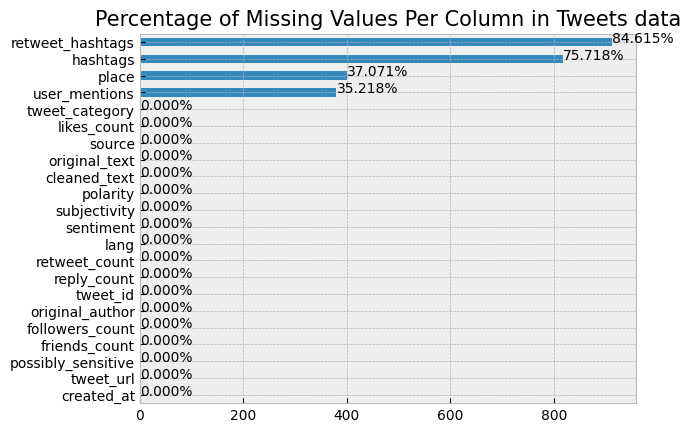

In [42]:
# Check the percentage of missing values in every column
ax = df_tweet.isna().sum().sort_values().plot(kind = 'barh')#, figsize = (7, 9))
plt.title('Percentage of Missing Values Per Column in Tweets data', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.3f}%'.format((p.get_width()/df_tweet.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

<AxesSubplot:ylabel='Place'>

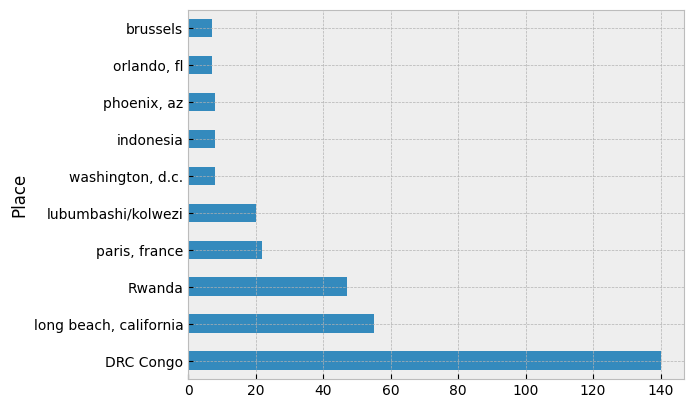

In [43]:
df_tweet['place'].value_counts(sort=True, ascending=False)[:10].plot(kind='barh',xlabel='Place')

In [44]:
df_tweet_date=df_tweet.set_index('created_at')

<AxesSubplot:xlabel='Date,time'>

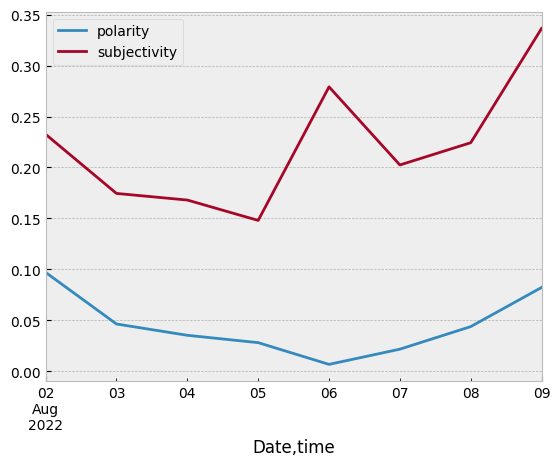

In [45]:
df_tweet_date.resample('D').mean()[['polarity','subjectivity']].dropna().plot(xlabel='Date,time')

### uni-variate Analysis on Hashtags


In [46]:
hashtag_df=df_tweet[['original_text','hashtags','retweet_hashtags']]

In [47]:
df_tweet['original_text']=df_tweet['original_text'].astype('str')

In [48]:
def find_hashtags(df_tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', df_tweet)

In [49]:
hashtag_df['hashtag_check']=df_tweet.original_text.apply(find_hashtags)

In [50]:
hashtag_df.dropna(subset=['hashtag_check'],inplace=True)

In [51]:
tags_list=list(hashtag_df['hashtag_check'])

In [52]:
hashtags_list_df = pd.DataFrame([tag for tags_row in tags_list for tag in tags_row],columns=['hashtag'])

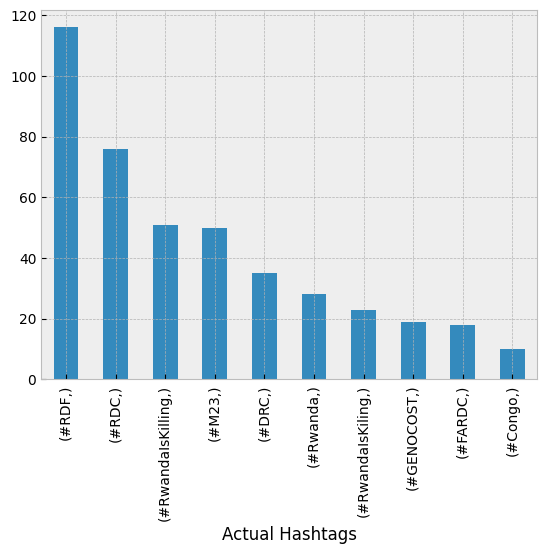

In [53]:
_=hashtags_list_df.value_counts()[:10].plot(kind='bar',xlabel='Actual Hashtags')

In [54]:
#Convert hastags to lowercase
hashtags_list_df['hashtag'] = hashtags_list_df['hashtag'].str.lower()

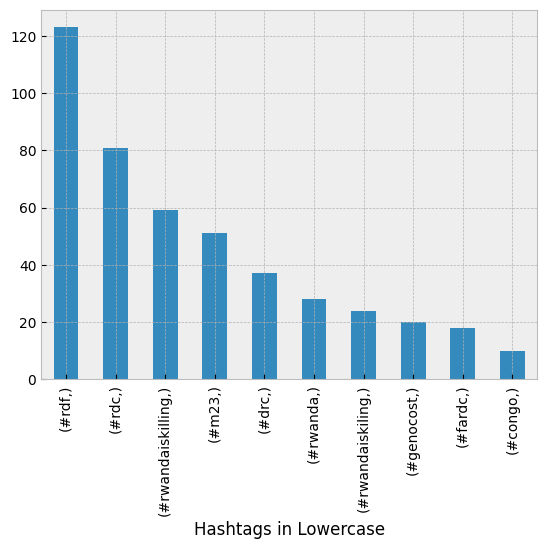

In [55]:
_=hashtags_list_df.value_counts()[:10].plot(kind='bar',xlabel='Hashtags in Lowercase')

In [56]:
user_summary=df_tweet.groupby('original_author').agg({'cleaned_text':'count','followers_count':'max',
                                         'polarity':'mean','subjectivity':'mean', 'sentiment':pd.Series.mode})

In [57]:
user_summary.sort_values(by='cleaned_text',ascending=False).head(10)

,cleaned_text,followers_count,polarity,subjectivity,sentiment
original_author,,,,,
Ariel_Dianzon,55,346,0.004556,0.190444,Neutral
Phil09202,20,124,0.030949,0.142801,Neutral
serkab061470,19,166,-0.000658,0.023246,Positive
bouche_bee,15,2857,-0.106667,0.133333,"[Neutral, Positive]"
gisele_kaj,12,14284,0.033333,0.083333,Positive
Piramidex11,10,11,-0.015000,0.090000,"[Negative, Positive]"
acute_tomato,10,17596,-0.116667,0.106667,Neutral
PatHaye67745536,9,21,-0.008083,0.491571,Negative
kayjoe66,8,17,-0.050000,0.087500,Positive


Sentiment summary of the tweets

In [58]:
text_grouped = df_tweet.groupby('sentiment').count()['cleaned_text'].reset_index()

In [59]:
text_grouped

,sentiment,cleaned_text
0,Negative,252
1,Neutral,393
2,Positive,434


<AxesSubplot:xlabel='sentiment', ylabel='count'>

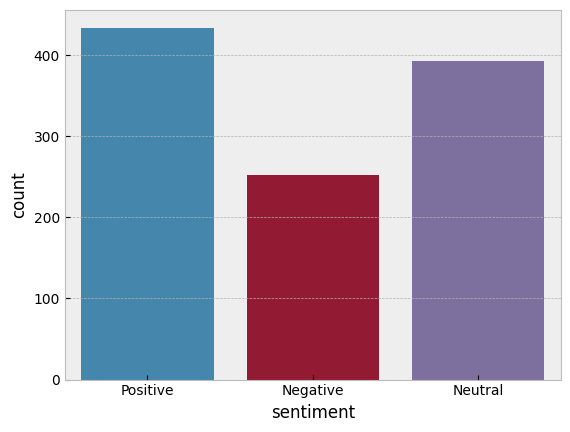

In [60]:
sns.countplot(x='sentiment', data=df_tweet)

**Most frequent words in our tweets dataset**

In [61]:
english_tweets=df_tweet.copy()

In [62]:
# text Preprocessing
english_tweets['cleaned_text'] = english_tweets['cleaned_text'].apply(
    lambda x: clean(x,
                    no_emoji=True,
                    lower=True,
                    no_punct=True,
                    no_line_breaks=True,
                    no_currency_symbols=True))

In [63]:
all_words=' '.join(english_tweets.cleaned_text.values)

In [64]:
wordcloud_obj=WordCloud(width=1000,height=600,stopwords=STOPWORDS).generate(all_words)

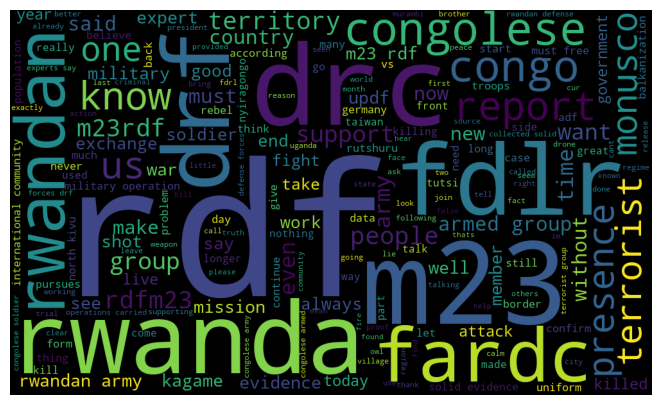

In [65]:
plt.figure(figsize=(10, 5))

fgg=plt.imshow(wordcloud_obj)
plt.axis('off')
# plt.title('Most Frequent Words In Our Tweets',fontsize=16)
plt.show()

In [66]:
# fgg.figure.savefig('plotly_dashboard/cw_rdf_week3.png',bbox_inches='tight',pad_inches=0)
# fgg.figure.savefig('plotly_dashboard/assets/cw_rdf_week3.png',bbox_inches='tight',pad_inches=0)

### Topic modeling

In [67]:
def preprocess_data(tweets_df):
    # Converting tweets to list of words For feature engineering
    sentence_list = [tweet for tweet in tweets_df['cleaned_text']]
    word_list = [sent.split() for sent in sentence_list]
    #Save only words and excludes emojis, punctuations
    word_list_new=[]
    for sent in word_list:
        word_list_new.append([re.split(r'\W+',word) for word in sent if word not in STOPWORDS and not word.isdigit()])
    
    word_list_final=[]
    for sent in word_list_new:
        word_list_final.append([i[0] for i in sent])
    # Create dictionary which contains Id and word 
    word_to_id = corpora.Dictionary(word_list_final)
    corpus_1 = [word_to_id.doc2bow(tweet) for tweet in word_list_final]

    return word_list_final, word_to_id, corpus_1

In [68]:
word_list, id2word, corpus=preprocess_data(english_tweets)

In [69]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=False)

In [70]:
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('rdf', 0.03933548),
   ('us', 0.006041126),
   ('know', 0.0054470026),
   ('good', 0.005398085),
   ('time', 0.0046197055),
   ('data', 0.004242048),
   ('taiwan', 0.004157724),
   ('need', 0.0039010057),
   ('one', 0.003836327),
   ('well', 0.0037319113)]),
 (1,
  [('rdf', 0.021542454),
   ('m23', 0.017439362),
   ('rwandan', 0.015636427),
   ('fardc', 0.012811717),
   ('congolese', 0.012418688),
   ('drc', 0.012077913),
   ('', 0.01039766),
   ('army', 0.009541132),
   ('rwanda', 0.009209041),
   ('fdlr', 0.008942578)]),
 (2,
  [('rdf', 0.020839779),
   ('case', 0.004547496),
   ('russia', 0.0039930097),
   ('', 0.00376802),
   ('back', 0.003688571),
   ('gas', 0.003169693),
   ('people', 0.002861487),
   ('face', 0.0027590098),
   ('side', 0.0027362586),
   ('state', 0.0025879159)])]


### Model Analysis

In [71]:
# Compute Perplexity

#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# doc_lda = lda_model[corpus]

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)


Perplexity:  -8.029668882975345

 Ldamodel Coherence Score/Accuracy on Tweets:  0.4922313707703097


**Model 1 words with some digits, 5 topics**

Perplexity:  -9.857909007134007\
Ldamodel Coherence Score/Accuracy on Tweets:  0.4242327533406264

**Model 2 words without digits, 5 topics**

Perplexity:  -9.82031321033761\
Ldamodel Coherence Score/Accuracy on Tweets:  0.4368570452021986

In [72]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.199856 -0.010900       1        1  50.251062
0      0.112813 -0.121344       2        1  27.825429
2      0.087042  0.132244       3        1  21.923509, topic_info=          Term        Freq       Total Category  logprob  loglift
6          m23  128.000000  128.000000  Default  30.0000  30.0000
495    rwandan  115.000000  115.000000  Default  29.0000  29.0000
134      fardc   94.000000   94.000000  Default  28.0000  28.0000
42   congolese   91.000000   91.000000  Default  27.0000  27.0000
375        drc   89.000000   89.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
40       using    5.869042    9.379485   Topic3  -6.3029   1.0488
208         us    8.104697   43.940900   Topic3  -5.9802  -0.1728
547        see    6.693783   20.805119   Topic3  -6.1714   0.3836
331       work    6.441579   16.719881   Topic3  -6.2098   0.5638
481       know    7.002340   29.800839   Topic3  -6.1264   0.0693

[162 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
490       1  0.855723            
490       3  0.135114            
4085      3  0.989384  alzawahiri
548       1  0.994937       armed
780       1  0.991656        army
...     ...       ...         ...
331       1  0.119618        work
331       2  0.478472        work
331       3  0.358854        work
15        1  0.549677       years
15        3  0.488602       years

[167 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

###  END

**Number of Topics optimatization**

As we can see the coherence accuracy increases with number of topics which is expected but again \
many topics again would lead to meaningless conclusion. Let's use elbow method to find optimum number of topics

In [ ]:
# # Find best LDA Model considering different number of topics

# params_dic={'topics_number':[],'coherence':[],'perplexity':[]}
# for top_number in range(1,10):
#     lda_model = gensim.models.ldamodel.LdaModel(corpus,
#                                             id2word=id2word,
#                                             num_topics=top_number, 
#                                             random_state=100,
#                                             update_every=1,
#                                             chunksize=100,
#                                             passes=10,
#                                             alpha='auto',
#                                             per_word_topics=False)
    
#     perplexity=lda_model.log_perplexity(corpus)  
#     # Compute Coherence Score
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     params_dic['topics_number'].append(top_number)
#     params_dic['coherence'].append(coherence_lda)
#     params_dic['perplexity'].append(perplexity)

In [ ]:
# pd.DataFrame(params_dic).plot(y=['coherence'])
# # pd.read_csv("elbow_metrics.csv",index_col=0).plot(y=['coherence'])

In [ ]:
# import numpy as np

In [ ]:
# alphas = list(np.arange(0.01, 3, 0.1))
# alphas.append('symmetric')
# alphas.append('asymmetric')
# alphas.append('auto')

In [ ]:
# # Find best LDA Model considering different number of alpha

# params_dic_alpha={'alpha':[],'coherence':[],'perplexity':[]}
# for alpha in alphas:
#     lda_model = gensim.models.ldamodel.LdaModel(corpus,
#                                             id2word=id2word,
#                                             num_topics=7, 
#                                             random_state=100,
#                                             update_every=1,
#                                             chunksize=100,
#                                             passes=10,
#                                             alpha=alpha,
#                                             per_word_topics=False)
    
#     perplexity=lda_model.log_perplexity(corpus)  
#     # Compute Coherence Score
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     params_dic_alpha['alpha'].append(alpha)
#     params_dic_alpha['coherence'].append(coherence_lda)
#     params_dic_alpha['perplexity'].append(perplexity)

In [ ]:
# pd.DataFrame(params_dic_alpha).plot(y='coherence')#.sort_values('coherence',ascending=False)

**Model with selected optimum parameters**

In [ ]:
# # Build LDA model
# lda_model = gensim.models.ldamodel.LdaModel(corpus,
#                                            id2word=id2word,
#                                            num_topics=7, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha=0.1,
#                                            per_word_topics=False)

In [ ]:
# pprint(lda_model.show_topics(formatted=False))

In [ ]:
# # Compute Perplexity
# #It's a measure of how good the model is. The lower the better. Perplexity is a negative value
# print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# # doc_lda = lda_model[corpus]

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)

In [ ]:
# # Visualize the topics
# pyLDAvis.enable_notebook()

# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
# LDAvis_prepared